https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/kmeans.py

In [0]:
import matplotlib.pyplot as plt
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)


def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

In [1]:
""" K-Means.
Implement K-Means algorithm with TensorFlow, and apply it to classify
handwritten digit images. This example is using the MNIST database of
handwritten digits as training samples (http://yann.lecun.com/exdb/mnist/).
Note: This example requires TensorFlow v1.1.0 or over.
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

# Ignore all GPUs, tf k-means does not benefit from it.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
full_data_x = mnist.train.images

# Parameters
num_steps = 50 # Total steps to train
batch_size = 1024 # The number of samples per batch
k = 25 # The number of clusters
num_classes = 10 # The 10 digits
num_features = 784 # Each image is 28x28 pixels


W0727 16:03:29.990632 140544969508736 deprecation.py:323] From <ipython-input-1-f1a8b8091574>:22: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0727 16:03:29.992784 140544969508736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0727 16:03:29.999306 140544969508736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be remove

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


W0727 16:03:30.693734 140544969508736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0727 16:03:30.700413 140544969508736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz


W0727 16:03:30.958645 140544969508736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Input images
X = tf.placeholder(tf.float32, shape=[None, num_features])
# Labels (for assigning a label to a centroid and testing)
Y = tf.placeholder(tf.float32, shape=[None, num_classes])

# K-Means Parameters
kmeans = KMeans(inputs=X, num_clusters=k, distance_metric='cosine',
                use_mini_batch=True)

# Build KMeans graph
training_graph = kmeans.training_graph()

if len(training_graph) > 6: # Tensorflow 1.4+
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     cluster_centers_var, init_op, train_op) = training_graph
else:
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     init_op, train_op) = training_graph

cluster_idx = cluster_idx[0] # fix for cluster_idx being a tuple
avg_distance = tf.reduce_mean(scores)

# Initialize the variables (i.e. assign their default value)
init_vars = tf.global_variables_initializer()

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars, feed_dict={X: full_data_x})
sess.run(init_op, feed_dict={X: full_data_x})

# Training
for i in range(1, num_steps + 1):
    _, d, idx = sess.run([train_op, avg_distance, cluster_idx],
                         feed_dict={X: full_data_x})
    if i % 10 == 0 or i == 1:
        print("Step %i, Avg Distance: %f" % (i, d))

# Assign a label to each centroid
# Count total number of labels per centroid, using the label of each training
# sample to their closest centroid (given by 'idx')
counts = np.zeros(shape=(k, num_classes))
for i in range(len(idx)):
    counts[idx[i]] += mnist.train.labels[i]
# Assign the most frequent label to the centroid
labels_map = [np.argmax(c) for c in counts]
labels_map = tf.convert_to_tensor(labels_map)

# Evaluation ops
# Lookup: centroid_id -> label
cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)
# Compute accuracy
correct_prediction = tf.equal(cluster_label, tf.cast(tf.argmax(Y, 1), tf.int32))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Test Model
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

W0727 16:06:11.184395 140544969508736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/factorization/python/ops/clustering_ops.py:740: calling l2_normalize (from tensorflow.python.ops.nn_impl) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


Step 1, Avg Distance: 0.341471
Step 10, Avg Distance: 0.221609
Step 20, Avg Distance: 0.220328
Step 30, Avg Distance: 0.219776
Step 40, Avg Distance: 0.219419
Step 50, Avg Distance: 0.219154
Test Accuracy: 0.7127


In [10]:
cls_pred = sess.run(cluster_label, feed_dict={X: test_x[:5], Y: test_y[:5]})
cls_pred

array([7, 2, 1, 0, 4], dtype=int32)

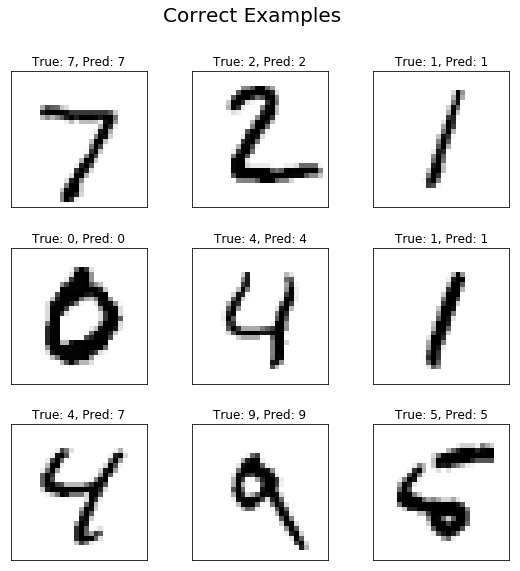

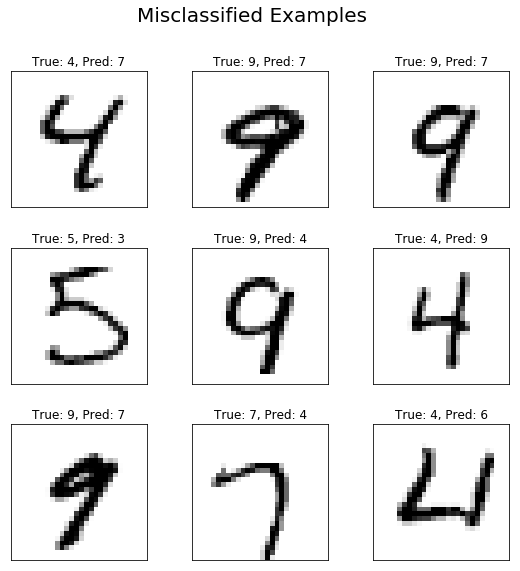

In [15]:
# Plot some of the correct and misclassified examples
cls_pred = sess.run(cluster_label, feed_dict={X: test_x, Y: test_y})
cls_true = np.argmax(test_y[:10000], axis=1)
plot_images(test_x, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(test_x[:10000], cls_true, cls_pred, title='Misclassified Examples')
plt.show()